# DCGAN in PyTorch

Dataset: MNIST

In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torchsummary import summary
# Just import the following libraries.

## Data

In [ ]:
# Time to load MNIST
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.MNIST("MNIST_data/", download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

testset = datasets.MNIST("MNIST_data/", download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=True)
# note we dont need the labels for DCGAN, we are just generating, not classifying

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Model

In [ ]:
from torch import nn, optim
from torch.nn import functional as F

In [ ]:
def weights_init(m):
  # We need this function to initialize weights, with normal initialization, so the
  # model trains properly
  classname = m.__class__.__name__
  if classname.find("Conv") != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

In [ ]:
def disc_conv(in_c, out_c, ks=4, stride=2, padding=1, bn=True, out_layer=False):
  layers = [nn.Conv2d(in_c, out_c, kernel_size=ks, stride=stride, padding=padding, bias=False)]
  if bn: layers.append(nn.BatchNorm2d(out_c))
  layers.append(nn.Sigmoid() if out_layer else nn.LeakyReLU(0.2, inplace=True))
  return nn.Sequential(*layers)

In [ ]:
D = nn.Sequential(
    disc_conv(1, 32, bn=False),
    disc_conv(32, 64),
    disc_conv(64, 128, ks=3),
    disc_conv(128, 1, out_layer=True, bn=False, padding=0)
)
D
# our discriminator is a fully convolutional network, it decides wheter image is real or fake

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (3): Sequential(
    (0): Conv2d(128, 1, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (1): Sigmoid()
  )
)

In [ ]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.layers = nn.Sequential(*[
                                  self.conv_block(100, 128, padding=0),
                                  self.conv_block(128, 64, stride=2, ks=3),
                                  self.conv_block(64, 32, stride=2),
                                  self.conv_block(32, 1, stride=2, bn=False, out_layer=True)
    ])
    # Our input is 100 dimensional random noise

  @staticmethod
  def conv_block(in_c, out_c, out_layer=False, ks=4, stride=1, padding=1, bias=False, bn=True):
    l = [nn.ConvTranspose2d(in_c, out_c, ks, stride=stride, padding=padding, bias=bias)]
    if bn: l.append(nn.BatchNorm2d(out_c))
    if out_layer: l.append(nn.Tanh())
    else: l.append(nn.ReLU(True))
    return nn.Sequential(*l)

  def forward(self, x):
    return self.layers(x)

In [ ]:
G = Generator()
G

Generator(
  (layers): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): Tanh()
    )
  )
)

In [ ]:
fixed_noise = torch.rand((64, 100, 1, 1))
G.apply(weights_init)
D.apply(weights_init)

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (3): Sequential(
    (0): Conv2d(128, 1, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (1): Sigmoid()
  )
)

In [ ]:
criterion = nn.BCELoss()

In [ ]:
optim_G = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optim_D = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
D = D.cuda()
G = G.cuda()
criterion = criterion.cuda()

## Training

In [ ]:
EPOCHS = 10
FAKE_LABEL = 0.0
REAL_LABEL = 1.0
for epoch in range(1, EPOCHS + 1):
  loss_d = 0.0
  loss_g = 0.0

  for i, (images, labels) in enumerate(trainloader):
    images = images.cuda()
    fake_labels = torch.full((images.size(0), ), FAKE_LABEL).cuda()
    real_labels = torch.full((images.size(0), ), REAL_LABEL).cuda()

    ## Train Discriminator ##
    D.zero_grad()

    d_real = D(images).view(-1)
    d_loss_real = criterion(d_real, real_labels)
    d_loss_real.backward()

    noise = torch.randn((images.size(0), 100, 1, 1)).cuda()
    fake_images = G(noise)

    d_fake = D(fake_images.detach()).view(-1)
    d_loss_fake = criterion(d_fake, fake_labels)
    d_loss_fake.backward()

    d_loss = d_loss_real + d_loss_fake
    optim_D.step()

    ## Train Generator ##
    G.zero_grad()

    d_fake = D(fake_images).view(-1)
    g_loss = criterion(d_fake, real_labels)
    g_loss.backward()

    optim_G.step()

    if i % 100 == 0:
      print(f"Epoch [{epoch}/{EPOCHS}], Batch [{i}], LOSS_D: {d_loss}, LOSS_G: {g_loss}")


Epoch [1/10], Batch [0], LOSS_D: 1.7642861604690552, LOSS_G: 0.9375284314155579
Epoch [1/10], Batch [100], LOSS_D: 0.2290143221616745, LOSS_G: 2.9240105152130127
Epoch [1/10], Batch [200], LOSS_D: 0.5470525026321411, LOSS_G: 3.3769168853759766
Epoch [1/10], Batch [300], LOSS_D: 0.4254148006439209, LOSS_G: 2.553520441055298
Epoch [1/10], Batch [400], LOSS_D: 0.19178634881973267, LOSS_G: 2.709446668624878
Epoch [2/10], Batch [0], LOSS_D: 0.12518391013145447, LOSS_G: 3.1467459201812744
Epoch [2/10], Batch [100], LOSS_D: 0.4182296395301819, LOSS_G: 1.9115915298461914
Epoch [2/10], Batch [200], LOSS_D: 0.1605975180864334, LOSS_G: 3.3139419555664062
Epoch [2/10], Batch [300], LOSS_D: 0.25613799691200256, LOSS_G: 2.5475449562072754
Epoch [2/10], Batch [400], LOSS_D: 0.26068180799484253, LOSS_G: 2.5732898712158203
Epoch [3/10], Batch [0], LOSS_D: 1.0324676036834717, LOSS_G: 1.3753254413604736
Epoch [3/10], Batch [100], LOSS_D: 0.4685435891151428, LOSS_G: 2.255018472671509
Epoch [3/10], Batch [

In [ ]:
# training takes a few minutes
# the losses will vary wildly, and they will just keep fluctuating like crazy
# but eventualy, the loss will slowly start to settle
# 10 epochs can generate some decent images,
# training seems to be going well

## Viewing Generated Images

In [ ]:
import numpy as np
import torchvision.utils as vutils

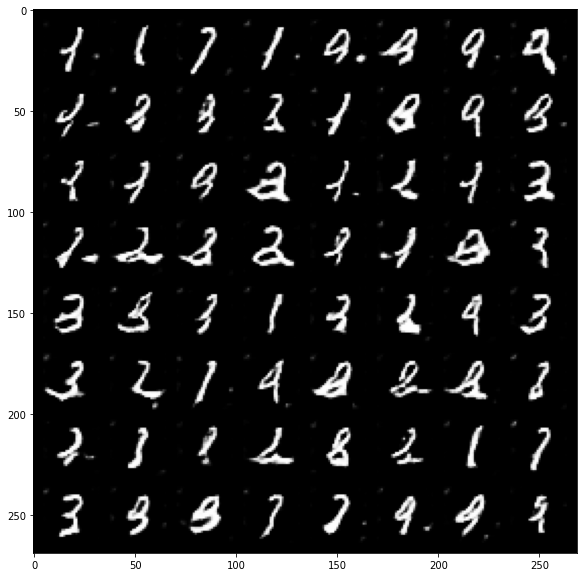

In [ ]:
fig = plt.figure(figsize=(10, 10))
rand_noise = torch.rand((64, 100, 1, 1))
out = vutils.make_grid(G(rand_noise.cuda()).cpu().detach(), padding=5, normalize=True)
plt.imshow(np.transpose(out.numpy(), (1, 2, 0)), cmap="gray")

In [ ]:
# You see we are generating decent images, We can recognize some of these digits, like the
# 3 in the bototm corner

## Thats it for thsi video, thank you for wathcing.
# Please subscribe and like and share this video.